In [2]:
pip install dalex

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 12.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for dalex: filename=dalex-1.6.0-py3-none-any.whl size=1045993 sha256=889f37e99fec785112c732d8ec3920dddd550f950e8b6f8d25209be0d2c6cb8c
  Stored in directory: /root/.cache/pip/wheels/c8/45/19/f5810bf7c5ff9a476ebd89bb5b81a18ffcdf93931d17dbb0c1
Successfully built dalex


In [3]:
pip install imbalanced-learn

In [4]:
pip install --upgrade imblearn

In [5]:
pip install lightgbm

In [6]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import dalex as dx
from dalex.fairness import resample, reweight, roc_pivot
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import dalex as dx
from dalex.fairness import resample, reweight, roc_pivot
from copy import copy
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import RandomOverSampler
import lightgbm as lgb

In [7]:
df = pd.read_csv("/content/stackoverflow_full.csv", index_col=0)
df

,Age,Accessibility,EdLevel,Employment,Gender,MentalHealth,MainBranch,YearsCode,YearsCodePro,Country,PreviousSalary,HaveWorkedWith,ComputerSkills,Employed
0,<35,No,Master,1,Man,No,Dev,7,4,Sweden,51552.0,C++;Python;Git;PostgreSQL,4,0
1,<35,No,Undergraduate,1,Man,No,Dev,12,5,Spain,46482.0,Bash/Shell;HTML/CSS;JavaScript;Node.js;SQL;Typ...,12,1
2,<35,No,Master,1,Man,No,Dev,15,6,Germany,77290.0,C;C++;Java;Perl;Ruby;Git;Ruby on Rails,7,0
3,<35,No,Undergraduate,1,Man,No,Dev,9,6,Canada,46135.0,Bash/Shell;HTML/CSS;JavaScript;PHP;Ruby;SQL;Gi...,13,0
4,>35,No,PhD,0,Man,No,NotDev,40,30,Singapore,160932.0,C++;Python,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73457,<35,No,Undergraduate,1,Man,No,Dev,7,2,Germany,41058.0,C#;HTML/CSS;JavaScript;TypeScript;Docker;Kuber...,13,1
73458,>35,No,Undergraduate,1,Man,No,Dev,21,16,United States of America,115000.0,C#;HTML/CSS;Java;JavaScript;npm;ASP.NET Core ;...,11,1
73459,<35,No,Undergraduate,1,Man,No,Dev,4,3,Nigeria,57720.0,HTML/CSS;JavaScript;TypeScript;Docker;Express;...,12,1
73460,<35,Yes,Undergraduate,1,Man,Yes,Dev,5,1,United States of America,70000.0,C#;HTML/CSS;JavaScript;SQL;TypeScript;npm;Yarn...,15,1


In [9]:
target = "Employed"

x_train, x_test, y_train, y_test = train_test_split(df.drop(columns=target), df[target], test_size=0.2, random_state=42)

In [10]:
protected = (pd.Series(np.where(x_test["Gender"] == "Woman", 'f', 'hnb'), index = x_test.index) + '_' + x_test.Age)

protected_train = (pd.Series(np.where(x_train["Gender"] == "Woman", 'f', 'hnb').astype(str), index=x_train.index) + '_' + x_train.Age)

privileged = 'hnb_<35'

In [11]:
for c in df.columns:
    col_type = df[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        df[c] = df[c].astype('category')

In [26]:
df.dtypes

Age               category
Accessibility     category
EdLevel           category
Employment           int64
Gender            category
MentalHealth      category
MainBranch        category
YearsCode            int64
YearsCodePro         int64
Country           category
PreviousSalary     float64
HaveWorkedWith    category
ComputerSkills       int64
Employed             int64
dtype: object

In [27]:
clf = lgb.LGBMClassifier()
clf.fit(x_train, y_train)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 31525, number of negative: 27244
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 950
[LightGBM] [Info] Number of data points in the train set: 58769, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.536422 -> initscore=0.145948
[LightGBM] [Info] Start training from score 0.145948


LGBMClassifier()

In [28]:
y_pred = clf.predict(x_test)
print(y_pred)

[1 1 0 ... 1 0 1]


[1 1 0 ... 1 0 1]


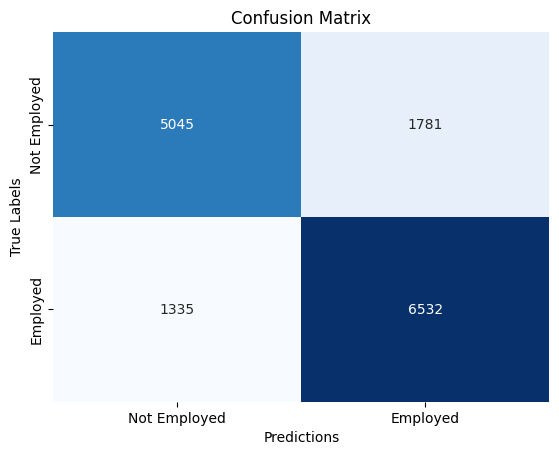

In [29]:
y_pred

#y_pred = (2.1*y_pred_proba).astype(int)
print(y_pred)

conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Employed', 'Employed'],
            yticklabels=['Not Employed', 'Employed'])
plt.title('Confusion Matrix')
plt.xlabel('Predictions')
plt.ylabel('True Labels')
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

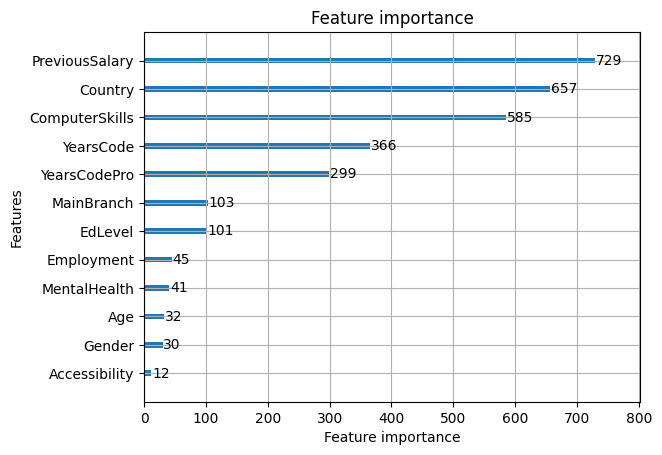

In [30]:
lgb.plot_importance(clf)

In [31]:
explainer = dx.Explainer(clf, x_test, y_test)

Preparation of a new explainer is initiated

  -> data              : 14693 rows 13 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 14693 values
  -> model_class       : lightgbm.sklearn.LGBMClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7e7aba5c9bd0> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.000561, mean = 0.533, max = 0.999
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.999, mean = 0.00259, max = 0.996
  -> model_info        : package lightgbm

A new explainer has been created!


In [32]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)


summary_table = pd.DataFrame({
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1],
})

print("Summary Table:")
print(summary_table)

Summary Table:
   Accuracy  Precision    Recall  F1 Score
0  0.787926   0.785757  0.830304  0.807417


In [33]:
fairness_object = explainer.model_fairness(protected=protected, privileged=privileged)

fairness_result = fairness_object.fairness_check() #valeur du seuil epsilon par défaut et égale à 0.8

print(fairness_result)



Bias detected in 2 metrics: FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on 'hnb_<35'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
              TPR       ACC       PPV       FPR       STP
f_<35    0.921498  0.984733  0.984829  0.815094  0.851916
f_>35    0.972222  1.054707  0.981037  0.581132  0.722997
hnb_>35  1.016908  1.007634  0.982301  0.996226  0.984321
None


In [34]:
explainer.model_performance().result

,recall,precision,f1,accuracy,auc
LGBMClassifier,0.830304,0.785757,0.807417,0.787926,0.873547


In [35]:
fairness_object.result

,TPR,TNR,PPV,NPV,FNR,FPR,FDR,FOR,ACC,STP
f_<35,0.921498,1.066667,0.984829,0.987163,1.377907,0.815094,1.057416,1.045249,0.984733,0.851916
f_>35,0.972222,1.151020,0.981037,1.112965,1.133721,0.581132,1.071770,0.601810,1.054707,0.722997
hnb_<35,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
hnb_>35,1.016908,1.001361,0.982301,1.041078,0.918605,0.996226,1.066986,0.855204,1.007634,0.984321


In [36]:
fairness_object.result

fairness_object.metric_scores

fairness_object.plot()


RESAMPLING


In [37]:
df.groupby(['Age', 'Gender']).agg('count')

Accessibility  EdLevel  Employment  MentalHealth  MainBranch  \
Age Gender                                                                    
<35 Man                44343    44343       44343         44343       44343   
    NonBinary            896      896         896           896         896   
    Woman               2580     2580        2580          2580        2580   
>35 Man                24230    24230       24230         24230       24230   
    NonBinary            475      475         475           475         475   
    Woman                938      938         938           938         938   

               YearsCode  YearsCodePro  Country  PreviousSalary  \
Age Gender                                                        
<35 Man            44343         44343    44343           44343   
    NonBinary        896           896      896             896   
    Woman           2580          2580     2580            2580   
>35 Man            24230         24230    24230           24230   
    NonBinary        475           475      475             475   
    Woman            938           938      938             938   

               HaveWorkedWith  ComputerSkills  Employed  
Age Gender                                               
<35 Man                 44308           44343     44343  
    NonBinary             896             896       896  
    Woman                2573            2580      2580  
>35 Man                 24213           24230     24230  
    NonBinary             474             475       475  
    Woman                 935             938       938

In [48]:
df.drop(df[df['Gender'] == "NonBinary"].index, inplace = True)
df1 = df.dropna()

In [39]:
df

,Age,Accessibility,EdLevel,Employment,Gender,MentalHealth,MainBranch,YearsCode,YearsCodePro,Country,PreviousSalary,HaveWorkedWith,ComputerSkills,Employed
0,<35,No,Master,1,Man,No,Dev,7,4,Sweden,51552.0,C++;Python;Git;PostgreSQL,4,0
1,<35,No,Undergraduate,1,Man,No,Dev,12,5,Spain,46482.0,Bash/Shell;HTML/CSS;JavaScript;Node.js;SQL;Typ...,12,1
2,<35,No,Master,1,Man,No,Dev,15,6,Germany,77290.0,C;C++;Java;Perl;Ruby;Git;Ruby on Rails,7,0
3,<35,No,Undergraduate,1,Man,No,Dev,9,6,Canada,46135.0,Bash/Shell;HTML/CSS;JavaScript;PHP;Ruby;SQL;Gi...,13,0
4,>35,No,PhD,0,Man,No,NotDev,40,30,Singapore,160932.0,C++;Python,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73456,<35,No,Master,1,Man,Yes,Dev,7,5,United States of America,94000.0,C;C#;C++;Microsoft Azure;SQLite,5,0
73457,<35,No,Undergraduate,1,Man,No,Dev,7,2,Germany,41058.0,C#;HTML/CSS;JavaScript;TypeScript;Docker;Kuber...,13,1
73458,>35,No,Undergraduate,1,Man,No,Dev,21,16,United States of America,115000.0,C#;HTML/CSS;Java;JavaScript;npm;ASP.NET Core ;...,11,1
73459,<35,No,Undergraduate,1,Man,No,Dev,4,3,Nigeria,57720.0,HTML/CSS;JavaScript;TypeScript;Docker;Express;...,12,1


In [73]:
oversample = RandomOverSampler(sampling_strategy=0.1)

In [74]:
x_train_res, y_train_res = oversample.fit_resample(df1.drop("Gender", axis = 1), df1["Gender"])


In [75]:
y_train_res.value_counts()

Man          68521
Woman         6852
NonBinary        0
Name: Gender, dtype: int64

In [76]:
x_train_res["Gender"] = y_train_res
x_train_res

df_bal = x_train_res

In [116]:
for c in df_bal.columns:
    col_type = df_bal[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        df_bal[c] = df_bal[c].astype('object')

In [117]:
target = "Employed"

x_train, x_test, y_train, y_test = train_test_split(df_bal.drop(columns=target), df_bal[target], test_size=0.2, random_state=42)


In [119]:


protected = (pd.Series(np.where(x_test["Gender"] == "Woman", 'f', 'hnb'), index = x_test.index) + '_' + x_test.Age)

protected_train = (pd.Series(np.where(x_train["Gender"] == "Woman", 'f', 'hnb').astype(str), index=x_train.index) + '_' + x_train.Age)

privileged = 'hnb_<35'

In [120]:
for c in df_bal.columns:
    col_type = df_bal[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        df_bal[c] = df_bal[c].astype('category')

In [121]:
target = "Employed"

x_train, x_test, y_train, y_test = train_test_split(df_bal.drop(columns=target), df_bal[target], test_size=0.2, random_state=42)


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 24158, number of negative: 21065
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1101
[LightGBM] [Info] Number of data points in the train set: 45223, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.534197 -> initscore=0.137003
[LightGBM] [Info] Start training from score 0.137003
[0 1 0 ... 0 0 0]


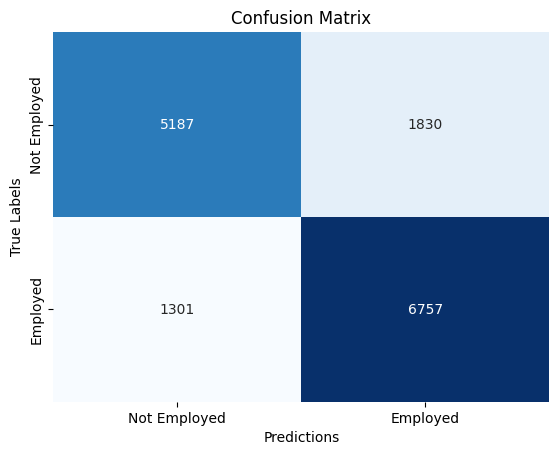

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

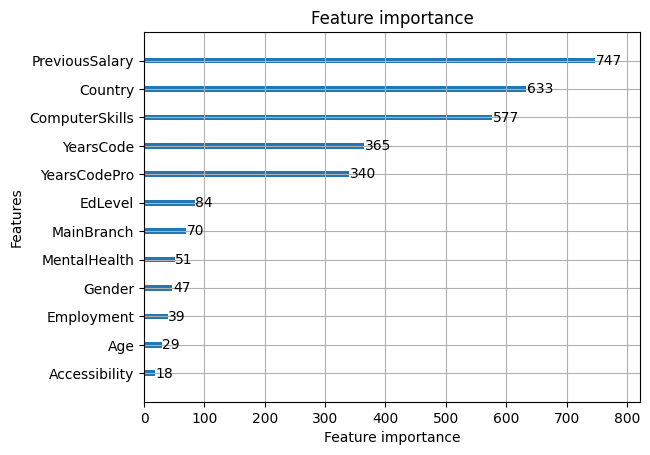

In [122]:

clf = lgb.LGBMClassifier()
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

y_pred

#y_pred = (2.1*y_pred_proba).astype(int)
print(y_pred)

conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Employed', 'Employed'],
            yticklabels=['Not Employed', 'Employed'])
plt.title('Confusion Matrix')
plt.xlabel('Predictions')
plt.ylabel('True Labels')
plt.show()

lgb.plot_importance(clf)

In [123]:
explainer = dx.Explainer(clf, x_test, y_test)

fairness_object = explainer.model_fairness(protected=protected, privileged=privileged)

fairness_result = fairness_object.fairness_check() #valeur du seuil epsilon par défaut et égale à 0.8

print(fairness_result)

fairness_object.result

fairness_object.metric_scores

fairness_object.plot()


Preparation of a new explainer is initiated

  -> data              : 15075 rows 13 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 15075 values
  -> model_class       : lightgbm.sklearn.LGBMClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7e7aba5c9bd0> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.000687, mean = 0.535, max = 0.999
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.998, mean = 1.06e-05, max = 0.994
  -> model_info        : package lightgbm

A new explainer has been created!
Bias detected in 2 metrics: FPR, STP

Conclusion: your model is not fair because 2 or more criteria exce

TEST


In [12]:
df = pd.read_csv("/content/stackoverflow_full.csv", index_col=0)
df

,Age,Accessibility,EdLevel,Employment,Gender,MentalHealth,MainBranch,YearsCode,YearsCodePro,Country,PreviousSalary,HaveWorkedWith,ComputerSkills,Employed
0,<35,No,Master,1,Man,No,Dev,7,4,Sweden,51552.0,C++;Python;Git;PostgreSQL,4,0
1,<35,No,Undergraduate,1,Man,No,Dev,12,5,Spain,46482.0,Bash/Shell;HTML/CSS;JavaScript;Node.js;SQL;Typ...,12,1
2,<35,No,Master,1,Man,No,Dev,15,6,Germany,77290.0,C;C++;Java;Perl;Ruby;Git;Ruby on Rails,7,0
3,<35,No,Undergraduate,1,Man,No,Dev,9,6,Canada,46135.0,Bash/Shell;HTML/CSS;JavaScript;PHP;Ruby;SQL;Gi...,13,0
4,>35,No,PhD,0,Man,No,NotDev,40,30,Singapore,160932.0,C++;Python,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73457,<35,No,Undergraduate,1,Man,No,Dev,7,2,Germany,41058.0,C#;HTML/CSS;JavaScript;TypeScript;Docker;Kuber...,13,1
73458,>35,No,Undergraduate,1,Man,No,Dev,21,16,United States of America,115000.0,C#;HTML/CSS;Java;JavaScript;npm;ASP.NET Core ;...,11,1
73459,<35,No,Undergraduate,1,Man,No,Dev,4,3,Nigeria,57720.0,HTML/CSS;JavaScript;TypeScript;Docker;Express;...,12,1
73460,<35,Yes,Undergraduate,1,Man,Yes,Dev,5,1,United States of America,70000.0,C#;HTML/CSS;JavaScript;SQL;TypeScript;npm;Yarn...,15,1


In [30]:
for c in df.columns:
    col_type = df[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        df[c] = df[c].astype('category')

In [31]:
target = "Employed"

x_train, x_test, y_train, y_test = train_test_split(df.drop(columns=target), df[target], test_size=0.2, random_state=42)

x_train, x_valf, y_train, y_valf = train_test_split(x_train, y_train, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2


In [16]:
df_unb = df.drop(columns = "Gender")

In [17]:
for c in df_unb.columns:
    col_type = df_unb[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        df_unb[c] = df_unb[c].astype('category')

In [18]:
target = "Employed"

x_train, x_test, y_train, y_test = train_test_split(df_unb.drop(columns=target), df[target], test_size=0.2, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2


In [19]:
df_unb.dtypes

Age               category
Accessibility     category
EdLevel           category
Employment           int64
MentalHealth      category
MainBranch        category
YearsCode            int64
YearsCodePro         int64
Country           category
PreviousSalary     float64
HaveWorkedWith    category
ComputerSkills       int64
Employed             int64
dtype: object

In [20]:
clf = lgb.LGBMClassifier()
clf.fit(x_train, y_train)

[LightGBM] [Info] Number of positive: 23634, number of negative: 20442
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 828
[LightGBM] [Info] Number of data points in the train set: 44076, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.536210 -> initscore=0.145095
[LightGBM] [Info] Start training from score 0.145095


LGBMClassifier()

In [21]:
y_pred = clf.predict(x_test)
print(y_pred)

[1 1 0 ... 1 0 1]


[1 1 0 ... 1 0 1]


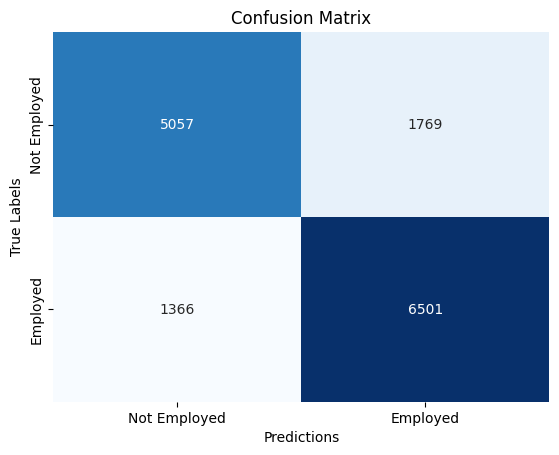

In [22]:
y_pred

#y_pred = (2.1*y_pred_proba).astype(int)
print(y_pred)

conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Employed', 'Employed'],
            yticklabels=['Not Employed', 'Employed'])
plt.title('Confusion Matrix')
plt.xlabel('Predictions')
plt.ylabel('True Labels')
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

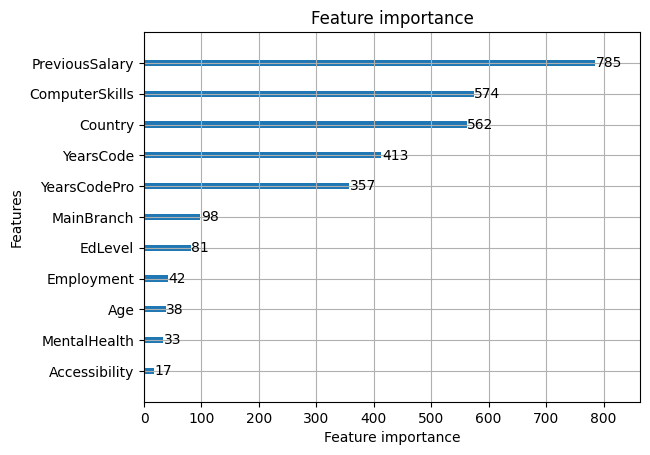

In [23]:
lgb.plot_importance(clf)

In [24]:
df_unbf = df_unb.drop(columns=target)

y_pred_unb = clf.predict(df_unbf)

df_unbf = df.drop(columns=target)

df_unbf["Employed"] = y_pred_unb

In [25]:
df_unbf

,Age,Accessibility,EdLevel,Employment,Gender,MentalHealth,MainBranch,YearsCode,YearsCodePro,Country,PreviousSalary,HaveWorkedWith,ComputerSkills,Employed
0,<35,No,Master,1,Man,No,Dev,7,4,Sweden,51552.0,C++;Python;Git;PostgreSQL,4,0
1,<35,No,Undergraduate,1,Man,No,Dev,12,5,Spain,46482.0,Bash/Shell;HTML/CSS;JavaScript;Node.js;SQL;Typ...,12,1
2,<35,No,Master,1,Man,No,Dev,15,6,Germany,77290.0,C;C++;Java;Perl;Ruby;Git;Ruby on Rails,7,0
3,<35,No,Undergraduate,1,Man,No,Dev,9,6,Canada,46135.0,Bash/Shell;HTML/CSS;JavaScript;PHP;Ruby;SQL;Gi...,13,1
4,>35,No,PhD,0,Man,No,NotDev,40,30,Singapore,160932.0,C++;Python,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73457,<35,No,Undergraduate,1,Man,No,Dev,7,2,Germany,41058.0,C#;HTML/CSS;JavaScript;TypeScript;Docker;Kuber...,13,1
73458,>35,No,Undergraduate,1,Man,No,Dev,21,16,United States of America,115000.0,C#;HTML/CSS;Java;JavaScript;npm;ASP.NET Core ;...,11,1
73459,<35,No,Undergraduate,1,Man,No,Dev,4,3,Nigeria,57720.0,HTML/CSS;JavaScript;TypeScript;Docker;Express;...,12,1
73460,<35,Yes,Undergraduate,1,Man,Yes,Dev,5,1,United States of America,70000.0,C#;HTML/CSS;JavaScript;SQL;TypeScript;npm;Yarn...,15,1


[LightGBM] [Info] Number of positive: 25041, number of negative: 19035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005019 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 832
[LightGBM] [Info] Number of data points in the train set: 44076, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568132 -> initscore=0.274235
[LightGBM] [Info] Start training from score 0.274235
[1 1 1 ... 0 1 1]
[1 1 1 ... 0 1 1]


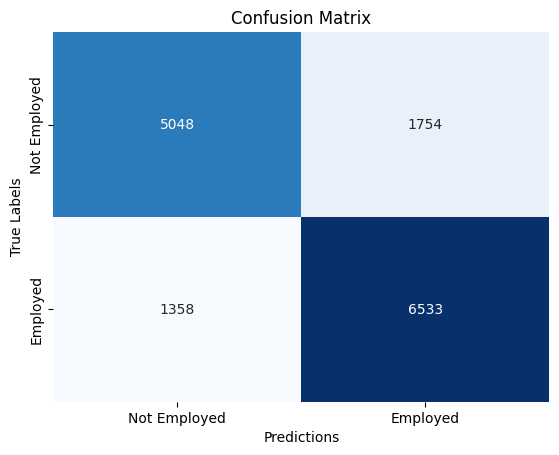

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

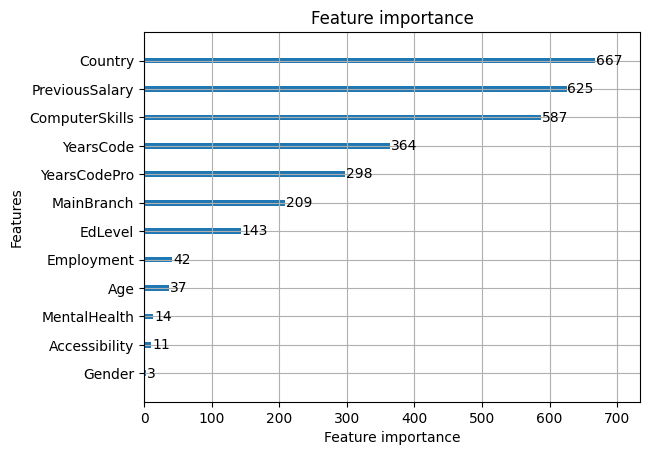

In [32]:
target = "Employed"

for c in df_unbf.columns:
    col_type = df_unbf[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        df_unbf[c] = df_unbf[c].astype('category')

x_train, x_test, y_train, y_test = train_test_split(df_unbf.drop(columns=target), df_unbf[target], test_size=0.2, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2


clf = lgb.LGBMClassifier()
clf.fit(x_train, y_train)

y_pred = clf.predict(x_valf)
print(y_pred)

y_pred

#y_pred = (2.1*y_pred_proba).astype(int)
print(y_pred)

conf_matrix = confusion_matrix(y_valf, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Employed', 'Employed'],
            yticklabels=['Not Employed', 'Employed'])
plt.title('Confusion Matrix')
plt.xlabel('Predictions')
plt.ylabel('True Labels')
plt.show()

lgb.plot_importance(clf)

In [34]:
explainer = dx.Explainer(clf, x_valf, y_valf)

fairness_object = explainer.model_fairness(protected=protected, privileged=privileged)

fairness_result = fairness_object.fairness_check() #valeur du seuil epsilon par défaut et égale à 0.8

print(fairness_result)

fairness_object.result

fairness_object.metric_scores

fairness_object.plot()


Preparation of a new explainer is initiated

  -> data              : 14693 rows 13 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 14693 values
  -> model_class       : lightgbm.sklearn.LGBMClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7ace7f9c51b0> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 7.49e-05, mean = 0.563, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -1.0, mean = -0.0259, max = 1.0
  -> model_info        : package lightgbm

A new explainer has been created!
No bias was detected!

Conclusion: your model is fair in terms of checked fairness criteria.

Ratios of metrics